In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import anndata as ad
import scAR

import warnings
warnings.simplefilter("ignore")

In [2]:
from matplotlib import pylab

params = {'legend.fontsize': 8,
          'figure.facecolor':"w",
          'figure.figsize': (6, 4.5),
         'axes.labelsize': 10,
         'axes.titlesize':10,
         'axes.linewidth': 0.5,
         'xtick.labelsize':8,
         'ytick.labelsize':8,
         'axes.grid':False,}
pylab.rc('font',**{'family':'serif','serif':['Palatino'],'size':10})
pylab.rcParams.update(params);

sns.set_palette("muted");
sns.set_style("ticks");

In [21]:
lane2 = sc.read_10x_h5(filename='/media/chang/HDD-1/chang/perturb/cellranger_outs/opl33_lane2/raw_feature_bc_matrix.h5',
                          gex_only=False)
lane2.var_names_make_unique()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [22]:
lane2_sgRNA_raw = lane2[:, lane2.var['feature_types']=='CRISPR Guide Capture'].to_df()

In [3]:
solo_lane2 = sc.read_10x_h5('/media/chang/HDD-1/chang/perturb/SL269_Solo.out/GeneFull_Ex50pAS/10x.h5')

In [4]:
solo_lane2.obs_names

Index(['AAACCCAAGAAACACT-1', 'AAACCCAAGAAACCAT-1', 'AAACCCAAGAAACCCA-1',
       'AAACCCAAGAAACCCG-1', 'AAACCCAAGAAACCTG-1', 'AAACCCAAGAAACGAA-1',
       'AAACCCAAGAAACGTC-1', 'AAACCCAAGAAACTAC-1', 'AAACCCAAGAAACTCA-1',
       'AAACCCAAGAAACTGC-1',
       ...
       'TTTGTTGTCTTTCTTC-1', 'TTTGTTGTCTTTGAGA-1', 'TTTGTTGTCTTTGATC-1',
       'TTTGTTGTCTTTGCAT-1', 'TTTGTTGTCTTTGCGC-1', 'TTTGTTGTCTTTGCTA-1',
       'TTTGTTGTCTTTGCTG-1', 'TTTGTTGTCTTTGGAG-1', 'TTTGTTGTCTTTGGCT-1',
       'TTTGTTGTCTTTGTCG-1'],
      dtype='object', length=6794880)

In [5]:
rank_UMIs = pd.DataFrame(solo_lane2[:,solo_lane2.var['feature_types']=='Gene Expression'].X.sum(axis=1), index = solo_lane2.obs_names, columns=['total_counts'])

rank_UMIs['droplets'] = 'cell-free droplets'
rank_UMIs['droplets'] = rank_UMIs['droplets'].mask(rank_UMIs['total_counts']>10, 'droplet II')
rank_UMIs['droplets'] = rank_UMIs['droplets'].mask(rank_UMIs['total_counts']>500, 'droplet I')
rank_UMIs['droplets'] = rank_UMIs['droplets'].mask(rank_UMIs['total_counts']>1500, 'cells')
rank_UMIs = rank_UMIs.sort_values(by='total_counts', ascending=False).reset_index().rename_axis("rank").reset_index()
rank_UMIs = rank_UMIs.loc[rank_UMIs['total_counts']>0]
rank_UMIs = rank_UMIs.set_index('index').rename_axis('cells')

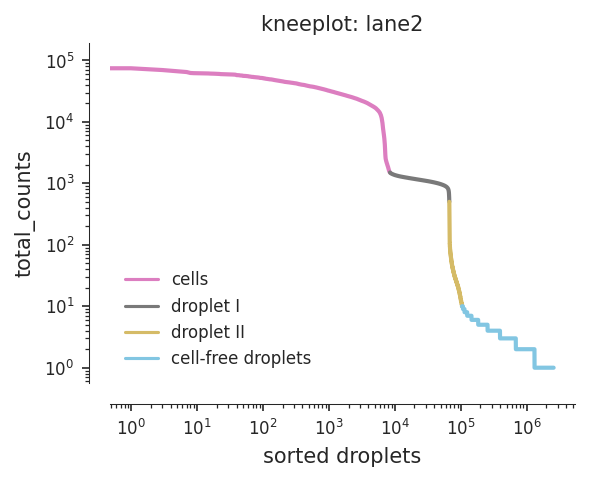

In [26]:
plt.figure(figsize=(4, 3), dpi=150)

ax = sns.lineplot(data = rank_UMIs,
                  x='rank',
                  y='total_counts',
                  hue='droplets',
                  hue_order=['cells', 'droplet I', 'droplet II', 'cell-free droplets'],
                  palette=sns.color_palette()[-4:],
                  markers=False,
                  lw=2)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('sorted droplets');
ax.legend(loc='lower left', ncol=1, title=None, frameon=False)
ax.set_title(f'kneeplot: lane2');

sns.set_palette("muted")
sns.set_style("ticks")
sns.despine(offset=10, trim=False);

In [11]:
lane2_filtered = lane2[lane2.obs_names.isin(rank_UMIs[rank_UMIs['droplets']=='cells'].index)] # equal to filtered population as cellranger output
lane2_sgRNAs_filtered = lane2_filtered[:, lane2_filtered.var['feature_types']=='CRISPR Guide Capture'].to_df() # pandas.DataFrame

In [17]:
lane2_sgRNAs_filtered

,KRT7-1,KRT7-2,KRT7-3,SPANXB1-1,SPANXB1-2,SPANXB1-3,KRT81-1,KRT81-2,KRT81-3,SPANXC-1,...,CKAP2L-3,NCCRP1-1,NCCRP1-2,NCCRP1-3,CKAP2-1,CKAP2-2,CKAP2-3,RPS6KL1-1,RPS6KL1-2,RPS6KL1-3
AAACCCAAGAGCCTGA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCCAAGGCGAAGG-1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCCAAGGCTTTCA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCCAAGGTAAACT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCCAAGTTGCATC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGCAGAAGTGC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTGTTGCAGCACAGA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTGTTGCATAGGCGA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTGTTGGTTCGCGTG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
lane2_empty_droplets_sgRNAs = lane2_sgRNA_raw.loc[lane2_sgRNA_raw.index.difference(lane2_sgRNAs_filtered.index)]
lane2_empty_profile_sgRNAs = lane2_empty_droplets_sgRNAs.sum()/lane2_empty_droplets_sgRNAs.sum().sum()    # pandas.Series

In [15]:
lane2_empty_profile_sgRNAs.values.shape

(1725,)

In [20]:
scarObj_lane2 = scAR.model(raw_count=lane2_sgRNAs_filtered,
                     empty_profile=lane2_empty_profile_sgRNAs.values, # In the case of default None, the empty_profile will be calculated by averaging pooled cells
                     scRNAseq_tech='CROPseq')

scarObj_lane2.train(epochs=400)

..Running VAE using the following param set:
......scAR mode:  CROPseq
......count model:  binomial
......num_input_feature:  1725
......NN_layer1:  150
......NN_layer2:  100
......latent_space:  15
......dropout_prob:  0
......kld_weight:  1e-05
......lr:  0.001
......lr_step_size:  5
......lr_gamma:  0.97
  Training.....
100%|██████████| 400/400 [09:16<00:00,  1.39s/it]
  Inferring .....


In [29]:
scarObj_lane2.inference(feature_type='sgRNAs',
                  cutoff=3)

  Inferring .....


In [30]:
scarObj_lane2.feature_assignment

,sgRNAs,n_sgRNAs
AAACCCAAGAGCCTGA-1,AMPH-2,1
AAACCCAAGGCGAAGG-1,VAMP8-5,1
AAACCCAAGGCTTTCA-1,XDH-1,1
AAACCCAAGGTAAACT-1,"AKAP12-3, non-targeting_00002",2
AAACCCAAGTTGCATC-1,C5orf46-3,1
...,...,...
TTTGTTGCAGAAGTGC-1,ZNF582-1,1
TTTGTTGCAGCACAGA-1,"SERPIND1-2, TFF1-2",2
TTTGTTGCATAGGCGA-1,GPSM3-1,1
TTTGTTGGTTCGCGTG-1,PSMB9-1,1


In [31]:
scarObj_lane2.feature_assignment.to_csv("/media/chang/HDD-1/chang/perturb/scAR_opl33_lane2.csv")

In [6]:
non_cell_droplets = solo_lane2[solo_lane2.obs_names.isin(rank_UMIs[rank_UMIs['droplets']=='cell-free droplets'].index)].X.sum(axis=0)
empty_profile=(non_cell_droplets/non_cell_droplets.sum()).A1
empty_profile

array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
       1.5752146e-06, 0.0000000e+00], dtype=float32)

In [7]:
raw_counts = solo_lane2.to_df()
raw_counts

,MIR1302-2HG,FAM138A,OR4F5,ENSG00000238009,ENSG00000239945,ENSG00000239906,ENSG00000241860,ENSG00000241599,ENSG00000286448,ENSG00000236601,...,ENSG00000275249,ENSG00000274792,ENSG00000274175,ENSG00000275869,ENSG00000273554,ENSG00000277836,ENSG00000278633,ENSG00000276017,ENSG00000278817,ENSG00000277196
AAACCCAAGAAACACT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCCAAGAAACCAT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCCAAGAAACCCA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCCAAGAAACCCG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCCAAGAAACCTG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
scarObj = scAR.model(raw_count=raw_counts.values,
                     empty_profile=empty_profile, # In the case of default None, the empty_profile will be calculated by averaging pooled cells
                     scRNAseq_tech='scRNAseq')

scarObj.train(epochs=400, batch_size=64)

# After training, we can infer the native true signal
scarObj.inference()  # by defaut, batch_size=None, set a batch_size if getting a GPU memory issue


In [ ]:
denoised_count = pd.DataFrame(scarObj_lane2.native_counts, index=lane2_sgRNAs_filtered.index, columns=lane2_sgRNAs_filtered.columns)

In [23]:
lane1 = sc.read_10x_h5(filename='/media/chang/HDD-1/chang/perturb/cellranger_outs/opl33_lane1/raw_feature_bc_matrix.h5',
                          gex_only=False)
lane1.var_names_make_unique()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [24]:
lane1_sgRNA_raw = lane1[:, lane1.var['feature_types']=='CRISPR Guide Capture'].to_df()

In [ ]:
solo_lane1 = sc.read_10x_h5('/media/chang/HDD-1/chang/perturb/SL268_Solo.out/GeneFull_Ex50pAS/10x.h5')

In [36]:
rank_UMIs = pd.DataFrame(lane1[:,lane1.var['feature_types']=='Gene Expression'].X.sum(axis=1), index = lane1.obs_names, columns=['total_counts'])

rank_UMIs['droplets'] = 'cell-free droplets'
rank_UMIs['droplets'] = rank_UMIs['droplets'].mask(rank_UMIs['total_counts']>10, 'droplet II')
rank_UMIs['droplets'] = rank_UMIs['droplets'].mask(rank_UMIs['total_counts']>500, 'droplet I')
rank_UMIs['droplets'] = rank_UMIs['droplets'].mask(rank_UMIs['total_counts']>3000, 'cells')
rank_UMIs = rank_UMIs.sort_values(by='total_counts', ascending=False).reset_index().rename_axis("rank").reset_index()
rank_UMIs = rank_UMIs.loc[rank_UMIs['total_counts']>0]
rank_UMIs = rank_UMIs.set_index('index').rename_axis('cells')

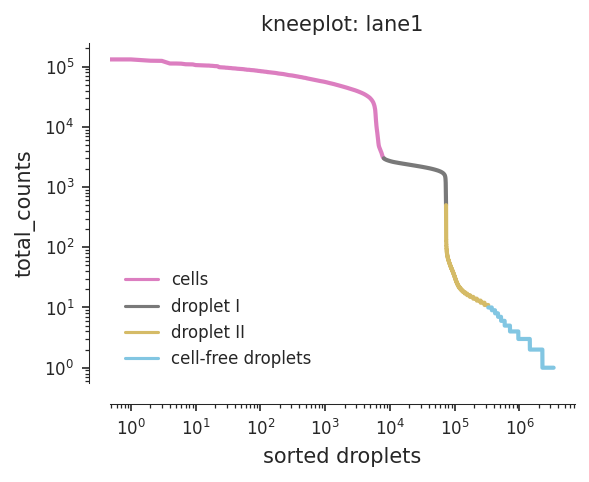

In [37]:
plt.figure(figsize=(4, 3), dpi=150)

ax = sns.lineplot(data = rank_UMIs,
                  x='rank',
                  y='total_counts',
                  hue='droplets',
                  hue_order=['cells', 'droplet I', 'droplet II', 'cell-free droplets'],
                  palette=sns.color_palette()[-4:],
                  markers=False,
                  lw=2)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('sorted droplets');
ax.legend(loc='lower left', ncol=1, title=None, frameon=False)
ax.set_title(f'kneeplot: lane1');

sns.set_palette("muted")
sns.set_style("ticks")
sns.despine(offset=10, trim=False);

In [38]:
lane1_filtered = lane1[lane1.obs_names.isin(rank_UMIs[rank_UMIs['droplets']=='cells'].index)] # equal to filtered population as cellranger output
lane1_sgRNAs_filtered = lane1_filtered[:, lane1_filtered.var['feature_types']=='CRISPR Guide Capture'].to_df() # pandas.DataFrame

In [39]:
lane1_empty_droplets_sgRNAs = lane1_sgRNA_raw.loc[lane1_sgRNA_raw.index.difference(lane1_sgRNAs_filtered.index)]
lane1_empty_profile_sgRNAs = lane1_empty_droplets_sgRNAs.sum()/lane1_empty_droplets_sgRNAs.sum().sum()    # pandas.Series

In [40]:
scarObj_lane1 = scAR.model(raw_count=lane1_sgRNAs_filtered,
                     empty_profile=lane1_empty_profile_sgRNAs.values, # In the case of default None, the empty_profile will be calculated by averaging pooled cells
                     scRNAseq_tech='CROPseq')

scarObj_lane1.train(epochs=400)

..Running VAE using the following param set:
......scAR mode:  CROPseq
......count model:  binomial
......num_input_feature:  1725
......NN_layer1:  150
......NN_layer2:  100
......latent_space:  15
......dropout_prob:  0
......kld_weight:  1e-05
......lr:  0.001
......lr_step_size:  5
......lr_gamma:  0.97
  Training.....
100%|██████████| 400/400 [08:49<00:00,  1.32s/it]


In [41]:
# After training, we can infer the native true signal
scarObj_lane1.inference(feature_type='sgRNAs',
                  cutoff=3)  # by defaut, batch_size=None, set a batch_size if getting a GPU memory issue

  Inferring .....


In [42]:
scarObj_lane1.feature_assignment

,sgRNAs,n_sgRNAs
AAACCCAAGGGATCGT-1,C5orf46-3,1
AAACCCAAGTCAGGGT-1,PXMP4-2,1
AAACCCACAATCAGCT-1,COL18A1-3,1
AAACCCAGTACCCGCA-1,CCBE1-3,1
AAACCCAGTACTGACT-1,non-targeting_00023,1
...,...,...
TTTGTTGCACCCTAAA-1,DNAAF3-6,1
TTTGTTGCAGACACAG-1,NCF2-3,1
TTTGTTGCATGCCGAC-1,CDC42EP5-2,1
TTTGTTGTCAGCATTG-1,VAV1-2,1


In [43]:
scarObj_lane1.feature_assignment.to_csv("/media/chang/HDD-1/chang/perturb/scAR_opl33_lane1.csv")